## <span style="color:#668B8B">Подключаем все необходимые библиотеки</span>

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from scipy.stats import chi2_contingency
from tqdm.auto import tqdm
import pandahouse as ph
import requests 
from urllib.parse import urlencode 
plt.style.use('ggplot')
%matplotlib inline

## <span style="color:#668B8B">Функция для bootstrap анализа</span>

In [2]:
def get_bootstrap(
    data_column_1,  # числовые значения первой выборки
    data_column_2,  # числовые значения второй выборки
    boot_it=1000,  # количество бутстрэп-подвыборок
    statistic=np.mean,  # интересующая нас статистика
    bootstrap_conf_level=0.95  # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)):  # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace=True  # параметр возвращения
        ).values        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace=True
        ).values        
        boot_data.append(statistic(samples_1) - statistic(samples_2))  # mean() - применяем статистику        
    pd_boot_data = pd.DataFrame(boot_data)        
    left_quant = (1 - bootstrap_conf_level) / 2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])        
    p_1 = norm.cdf(
        x=0, 
        loc=np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_2 = norm.cdf(
        x=0, 
        loc=- np.mean(boot_data), 
        scale=np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins=50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('#B22222')
        else: 
            bar.set_facecolor('#B0C4DE')
            bar.set_edgecolor('black')
    # 'grey'red
    plt.style.use('ggplot')
    plt.vlines(quants, ymin=0, ymax=50, linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

# <span style="color:#668B8B">Функция для загрузки файлов с яндекс диска</span>

In [3]:
def donload_csv(links):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'  # Получаем api
    # Получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=links))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url

# <span style="color:#43CD80"> Проект: вариант 2</span>

##############################################################################################################################

# <span style="color:#668B8B"> Задание 1. A/B–тестирование</span>

##############################################################################################################################

#### <span style="color:#668B8B">1.1 Условие</span>
#### <span style="color:#668B8B">Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.</span>

#### <span style="color:#668B8B">1.2 Входные данные</span>
##### <span style="color:#668B8B">В качестве входных данных Вы имеете 4 csv-файла:</span>
- ##### <span style="color:#668B8B">[groups.csv](https://disk.yandex.ru/d/UhyYx41rTt3clQ)  - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)</span> 
- ##### <span style="color:#668B8B">[groups_add.csv](https://disk.yandex.ru/d/5Kxrz02m3IBUwQ)  - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных</span>
- ##### <span style="color:#668B8B">[active_studs.csv](https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ)  - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.</span> 
- ##### <span style="color:#668B8B">[checks.csv](https://disk.yandex.ru/d/pH1q-VqcxXjsVA)  - файл с информацией об оплатах пользователей в дни проведения эксперимента.</span> 

#### <span style="color:#668B8B">1.3 Вопросы</span>
##### <span style="color:#668B8B">Предлагаем Вам ответить на следующие вопросы:</span>
- ##### <span style="color:#668B8B">На какие метрики Вы смотрите в ходе анализа и почему?</span>
- ##### <span style="color:#668B8B">Имеются ли различия в показателях и с чем они могут быть связаны?</span>
- ##### <span style="color:#668B8B">Являются ли эти различия статистически значимыми?</span>
- ##### <span style="color:#668B8B">Стоит ли запускать новую механику на всех пользователей?</span>
- ##### <span style="color:#668B8B">Данный список вопросов не является обязательным, и Вы можете при своём ответе опираться на собственный план.</span>

#### <span style="color:#668B8B">1.4 Требования к ответу</span>
##### <span style="color:#668B8B">При выполнении тестового задания необходимо использовать язык программирования Python.</span>
##### <span style="color:#668B8B">В файле обязательно должны быть комментарии к тем действиям, которые Вы выполняете с данными. </span>
##### <span style="color:#668B8B">Файл должен представлять собой законченный отчёт с выводами, сделанными в ходе исследования.</span>

## <span style="color:#36648B"> Произведем загрузку данных с яндекс диска в ДФ</span>

In [4]:
a = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
b = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
c = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
d = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

In [5]:
groups = pd.read_csv(donload_csv(a), sep=';')
groups_add = pd.read_csv(donload_csv(b))
active_studs = pd.read_csv(donload_csv(c))
checks = pd.read_csv(donload_csv(d), sep=';')

## <span style="color:#36648B">Посмотрим на данные из таблиц (тип данных, колличество записей и т.д.)</span>

In [6]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [7]:
groups.dtypes

id      int64
grp    object
dtype: object

In [8]:
groups.shape

(74484, 2)

In [9]:
groups_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [10]:
groups_add.dtypes

id      int64
grp    object
dtype: object

In [11]:
groups_add.shape

(92, 2)

In [12]:
active_studs.head()

,student_id
0,581585
1,5723133
2,3276743
3,4238589
4,4475369


In [13]:
active_studs.dtypes

student_id    int64
dtype: object

In [14]:
active_studs.shape

(8341, 1)

In [15]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [16]:
checks.dtypes

student_id      int64
rev           float64
dtype: object

In [17]:
checks.shape

(541, 2)

## <span style="color:##668B8B">Подготовим данные для анализа</span>
## <span style="color:#36648B">Соединим таблицу "groups.csv" с данными которые прислали спустя 2 дня "groups_add.csv"</span>

In [18]:
gr = groups.merge(groups_add, how='outer')

In [19]:
gr

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A
...,...,...
74571,200247820,B
74572,201032527,B
74573,201067612,B
74574,201067653,B


## <span style="color:#36648B">Оставим только активных пользователей которые зашли на платформу во время проведения эксперемента "active_studs.csv" </span>

In [20]:
# для удобства объединения переименуем колонку с student_id на id
active_studs = active_studs.rename(columns={'student_id': 'id'})  

In [21]:
gr_act = active_studs.merge(gr)

In [22]:
gr_act

,id,grp
0,581585,A
1,5723133,A
2,3276743,B
3,4238589,A
4,4475369,B
...,...,...
8336,1794344,B
8337,296883,B
8338,3598448,B
8339,3610547,B


## <span style="color:#36648B">Добавим данные о пользователях которые совершили оплату </span>

In [23]:
# для удобства объединения переименуем колонку с student_id на id
checks = checks.rename(columns={'student_id': 'id'})  

In [24]:
gr_act_checks = checks.merge(gr_act)
gr_act_checks

,id,rev,grp
0,1627,990.0000,A
1,100300,990.0000,B
2,108270,290.0000,B
3,264473,1900.0001,B
4,274352,690.0000,B
...,...,...,...
387,5645737,1900.0000,B
388,5651566,1900.0000,B
389,5662322,1900.0000,B
390,5681918,1900.0000,B


In [25]:
checks.nunique() - gr_act_checks.nunique()

grp      NaN
id     149.0
rev      1.0
dtype: float64

#### <span style="color:#43CD80">Мы видим, что в "checks.csv" есть пользователи кторых нет в файле активных пользователей "active_studs.csv" их 149 человек отсюда можно сделать вывод, что файл "active_studs.csv" не полный и сложно будет сказать эксперемент удачный или нет</span>

In [26]:
gr_act_checks.groupby('grp', as_index=False).agg({'id': 'count'})

,grp,id
0,A,78
1,B,314


In [27]:
gr_act_checks.rev.sort_values(ascending=False).head(20)

133    4650.0
47     3660.0
153    3660.0
128    3660.0
24     3660.0
366    3660.0
11     3260.0
110    3040.0
87     2910.0
14     2910.0
343    2910.0
136    2910.0
33     2900.0
313    2890.0
96     2890.0
177    2890.0
280    2890.0
161    2820.0
17     2820.0
238    2220.0
Name: rev, dtype: float64

In [28]:
gr_act_checks.groupby('grp', as_index=False).agg({'rev': 'mean'})

,grp,rev
0,A,933.589744
1,B,1257.878992


In [29]:
gr_act_checks.groupby('grp', as_index=False).agg({'rev': 'median'})

,grp,rev
0,A,585.0
1,B,1140.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


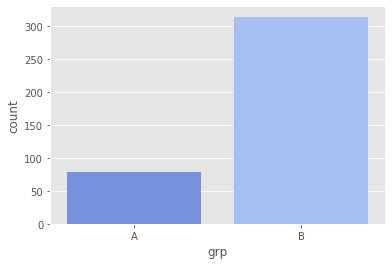

In [30]:
sns.set_palette("coolwarm")
sns.countplot(gr_act_checks.grp)

#### <span style="color:#43CD80">Видим что группа В значительно больше чем группа А</span>

In [31]:
ss.normaltest(gr_act_checks.rev)  # проведем тест на нормальность распределения 

NormaltestResult(statistic=24.143654186383895, pvalue=5.718368084494108e-06)

#### <span style="color:#43CD80">pvalue больше 0.05 что означает, что выборка с ненормальным распределением.</span>

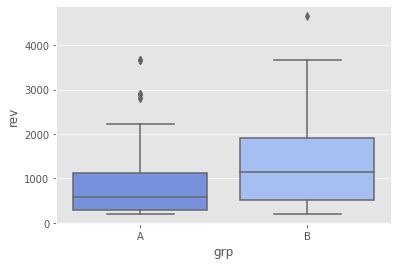

In [32]:
sns.set_palette("coolwarm")
sns.boxplot(x="grp", y="rev", data=gr_act_checks)

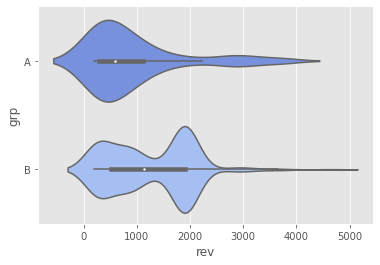

In [33]:
sns.set_palette("coolwarm")
sns.violinplot(x='rev', y='grp', data=gr_act_checks)

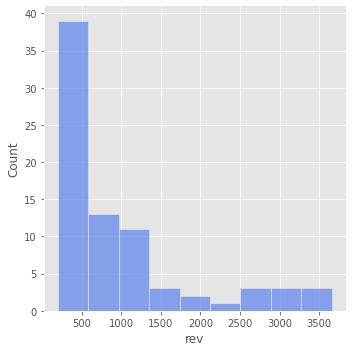

In [34]:
sns.set_palette("coolwarm")
sns.displot(gr_act_checks[gr_act_checks.grp == 'A'].rev, kde=False)

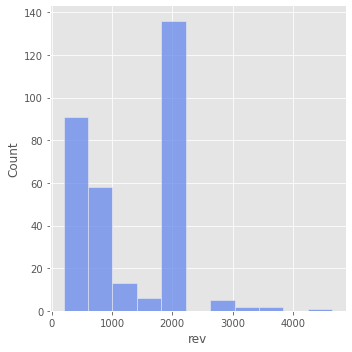

In [35]:
sns.set_palette("coolwarm")
sns.displot(gr_act_checks[gr_act_checks.grp == 'B'].rev, kde=False)

#### <span style="color:#43CD80">Так же видно что распределение не нормальное на графиках и есть выбросы</span>

In [36]:
grp1 = gr_act_checks.groupby(['rev', 'grp'], as_index=False).agg({'id': 'count'}).rename(columns={'id': 'user_count'})

In [37]:
grp1.sort_values('user_count', ascending=False).head(20)

,rev,grp,user_count
36,1900.0000,B,93
3,290.0000,B,45
37,1900.0001,B,35
1,199.0000,B,27
2,290.0000,A,25
17,840.0000,B,21
22,990.0000,B,17
14,690.0000,B,13
26,1140.0000,B,9
5,398.0000,B,6


#### <span style="color:#43CD80">видно что в группе В есть резкое увеличение покупок на сумму 1900, что может являтся выбросом</span> 

#### <span style="color:#668B8B">На какие метрики Вы смотрите в ходе анализа и почему?</span>

#### <span style="color:#43CD80">CR в покупку при помощи этой метрики мы можем увидеть сколько пользователей совершили покупку тоесть совершили действие в тестовой и контрольной группах.</span>

#### <span style="color:#43CD80">ARPU эта метрика, которая помогает рассчитывать среднюю выручку на пользователя. При помощи этой метрики мы сможем посмотреть стала ли новая механика приносить доход бизнесу или нет.</span>
    
#### <span style="color:#43CD80">ARPPU эта метрика, которая показывает среднюю прибыль на одного пользователя целевой группы и контрольной группы в результате чего мы увидим увеличился доход на пользователя при новой механики  или нет.</span>

In [38]:
# CR в покупку=колличество клиентов совершивших покупку/колличество клиентов пришедших на платформу*100%
# ARPU=доход/на общее кол-во пользователей
# ARPPU=доход/на колличество пользователей совершивших покупку

In [39]:
# Для удобства расчетов сведем всех пользователей в одну тоблицу 
# и оставим только тех пользователей по котрым есть данные

In [40]:
users_active = gr_act.merge(checks, how='left')

In [41]:
users_active = users_active.fillna(0)

#### <span style="color:#43CD80">Посчитаем метрики</span>

In [42]:
metrics = users_active.groupby('grp', as_index=False).agg({'rev': 'count'}).rename(columns={'rev': 'total_users'})

In [43]:
metrics['made_purchase'] = users_active.query('rev>0').groupby('grp', as_index=False).agg({'rev': 'count'}).rev

In [44]:
metrics['did_not_make_purchase'] = users_active.query('rev==0').groupby('grp', as_index=False).agg({'rev': 'count'}).rev

In [45]:
metrics['revenue'] = round(users_active.groupby('grp', as_index=False).agg({'rev': 'sum'}).rev, 2)

In [46]:
metrics['CR'] = round(metrics.made_purchase / metrics.total_users * 100, 2)

In [47]:
metrics['ARPU'] = round(metrics.revenue / metrics.total_users, 2)

In [48]:
metrics['ARPPU'] = round(metrics.revenue / metrics.made_purchase, 2)

In [49]:
metrics

,grp,total_users,made_purchase,did_not_make_purchase,revenue,CR,ARPU,ARPPU
0,A,1538,78,1460,72820.0,5.07,47.35,933.59
1,B,6803,314,6489,394974.0,4.62,58.06,1257.88


#### <span style="color:#43CD80">Мы видим различия между 2 группами, но они не велики для более точного ответа проведем А/В тесты для определения стат. значимости</span>

#### <span style="color:#43CD80">CR</span>

#### <span style="color:#668B8B"> Сформируем гипотезу о статистической значимости 0 гипотезы, что новая система оплата услуг на сайте, не увеличила количество пользователей которые совершили покупку.альтернативная гипотиза, что новая система оплата услуг на сайте, увеличила количество пользователей которые совершили покупку. Предполагая уровень значимости 0.05.</span>
#### <span style="color:#43CD80">проведем 2 теста методом Хи квадрат и методом bootstrap.</span>

In [50]:
hi_CR = metrics[['made_purchase', 'did_not_make_purchase']]

In [51]:
hi_CR

,made_purchase,did_not_make_purchase
0,78,1460
1,314,6489


In [52]:
p_value = chi2_contingency(hi_CR, correction=True)[1]
print("p-value:", p_value)

p-value: 0.48625240457231045


In [53]:
# для бутстрап анализа проведем предобработку данных
users_c = users_active.groupby(['rev', 'grp'], as_index=False).agg({'id': 'count'}).rename(columns={'id': 'user_count'})

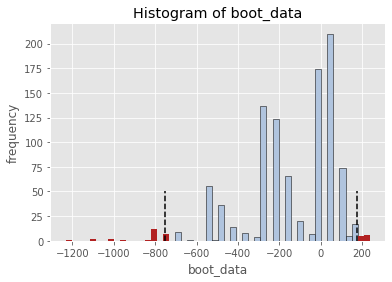

In [54]:
boot_cr = get_bootstrap(users_c[users_c.grp == 'A'].user_count, users_c[users_c.grp == 'B'].user_count)

In [55]:
boot_cr["p_value"]

0.550001930838762

In [56]:
 boot_cr['quants']

,0
0.025,-752.879167
0.975,173.897917


#### <span style="color:#43CD80">Вывод: p-value > 0.05 в обоих тестах, что показывает нет оснований отклонять 0-ю гипотезу при уровне значимости меньше 0.05, новая механика оплаты не повлияла на конверсию.</span>

#### <span style="color:#43CD80">ARPU</span>

#### <span style="color:#668B8B">Сформируем гипотезу о статистической значимости 0 гипотезы, что новая система оплата услуг на сайте, не увеличила среднюю выручку на активного пользователя. Альтернативная гипотиза, что новая система оплата услуг на сайте, увеличила среднюю выручку на активного пользователя. Предполагая уровень значимости 0.05.</span>
#### <span style="color:#43CD80">проведем тест методом bootstrap.</span>

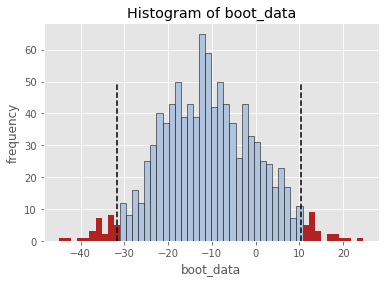

In [57]:
bootstrapARPU = get_bootstrap(users_active[users_active.grp == 'A'].rev, users_active[users_active.grp == 'B'].rev)

In [58]:
bootstrapARPU["p_value"]

0.3215766945410977

In [59]:
bootstrapARPU['quants']

,0
0.025,-31.713395
0.975,10.308046


#### <span style="color:#43CD80">Вывод: p-value > 0.05, что показывает нет оснований отклонять 0-ю гипотезу при уровне значимости меньше 0.05, новая механика оплаты не повлияла на среднюю выручку на активного пользователя.</span>

#### <span style="color:#43CD80">ARPPU</span>

#### <span style="color:#668B8B">Сформируем гипотезу о статистической значимости 0 гипотезы, что новая система оплата услуг на сайте, не увеличила среднюю прибыль на одного пользователя. Aльтернативная гипотиза, что новая система оплата услуг на сайте,  увеличила среднюю прибыль на одного пользователя. Предполагая уровень значимости 0.05.</span>
#### <span style="color:#43CD80">проведем тест методом bootstrap.</span>

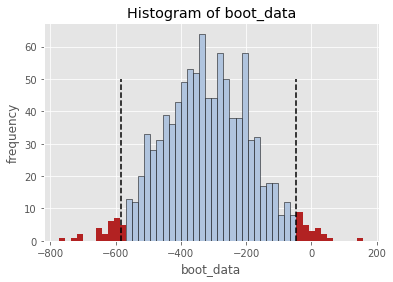

In [60]:
bootstrapARPPU = get_bootstrap(gr_act_checks[gr_act_checks.grp == 'A'].rev, gr_act_checks[gr_act_checks.grp == 'B'].rev)

In [61]:
bootstrapARPPU["p_value"]

0.017772515050299788

In [62]:
bootstrapARPPU["quants"]

,0
0.025,-581.919881
0.975,-46.385905


#### <span style="color:#43CD80">Вывод: p-value < 0.05, что показывает основания отклонить 0-ю гипотезу есть при уровне значимости меньше 0.05, новая механика оплаты повлияла на среднюю прибыль на одного пользователя.</span>

## <span style="color:#43CD80">Вывод по всем А/Б тестам: при проведении 4-х тестах статистическую значимость мы увидели только в 1-м тесте ARPPU на это мог повлиять выброс на сумму оплаты в 1900, который может быть связан с внешним фактором или факторами, а не с механикой оплаты. Я думаю оснований для запуска новой миханики оплаты нет.</span>

###############################################################################################################################

# <span style="color:#668B8B"> Задание 2. SQL</span>

###############################################################################################################################

#### <span style="color:#668B8B">2.1 Очень усердные ученики.</span>
#### <span style="color:#668B8B">2.1.1 Условие</span>
#### <span style="color:#668B8B">Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".</span>
#### <span style="color:#668B8B">Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.</span>
#### <span style="color:#668B8B">2.1.2 Задача</span>
#### <span style="color:#668B8B">Дана таблица default.peas:</span>

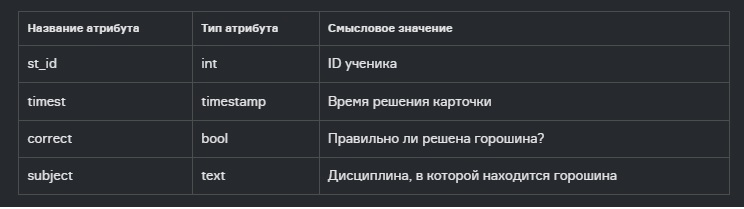

#### <span style="color:#668B8B">Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц.</span>

In [63]:
# Подключаемся к ClickHouse за ранее подключив библиотеку
connection_default = {'host': 'http://clickhouse.beslan.pro:8080',
                      'database': 'default',
                      'user': 'student', 
                      'password': 'dpo_python_2020'}

In [64]:
q1 = """SELECT
  any(timest) as date,
  --считаем сколько учеников сдало 20 и более горошин
  COUNT(st_id) as count_id 
FROM
  (
    SELECT
      st_id,
      --считаем сколько горошин решил ученик
      SUM(correct) as decided, 
      -- приводим дату к началу месяца
      toStartOfMonth(timest) as timest 
    FROM
      default.peas
    GROUP BY
      st_id,
      timest
    HAVING
      --оставляем тех учеников которые решили 20 горошин и более
      decided >=20 
  ) """

In [65]:
diligent_user = ph.read_clickhouse(q1, connection=connection_default)
print('колличество усердных пользователей:', diligent_user.count_id[0], 'человек')
diligent_user

колличество усердных пользователей: 136 человек


,date,count_id
0,2021-10-01,136


## <span style="color:#43CD80">Ответ - колличество усердных пользователей: 136 человек</span>

#### <span style="color:#668B8B">2.2.2 Задача</span>

#### <span style="color:#668B8B">Дана таблицы: default.peas (см. выше), default.studs:</span>

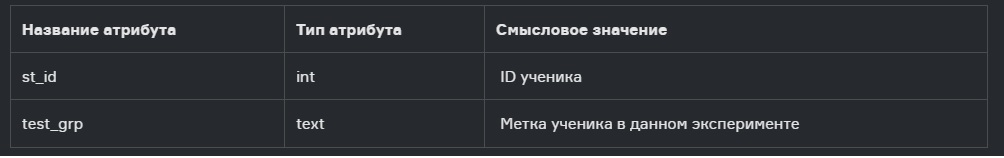

#### <span style="color:#668B8B">и default.final_project_check:</span>

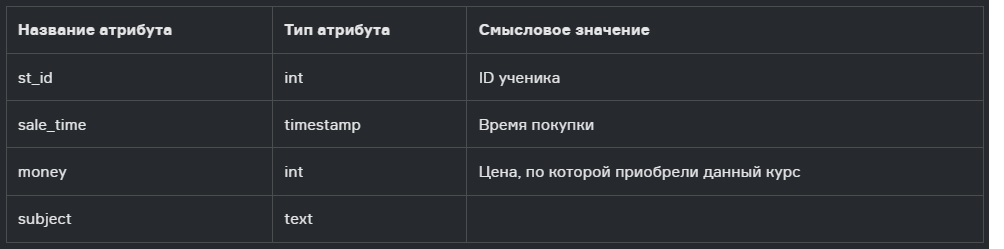

#### <span style="color:#668B8B">Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:</span>

- #### <span style="color:#668B8B">ARPU</span> 
- #### <span style="color:#668B8B">ARPAU</span> 
- #### <span style="color:#668B8B">CR в покупку</span> 
- #### <span style="color:#668B8B">СR активного пользователя в покупку</span> 
- #### <span style="color:#668B8B">CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике</span>

#### <span style="color:#668B8B">ARPU считается относительно всех пользователей, попавших в группы.</span>
#### <span style="color:#668B8B">Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.</span>
#### <span style="color:#668B8B">Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.</span>

## <span style="color:#43CD80">Запрос</span>

In [66]:
q2 = """SELECT
  test_grp,
  -- расчитываем ARPU=сумма опл-ых кусов/всех пользователей
  round(sum(money) / uniqExact(studs.st_id), 2) as ARPU,
  -- расч-ем ARPAU=сумма опл-ых кусов(если решено больше 10 горошин)/всех пользов-ей (если решено > 10 горошин)
  round(sumIf(project_check.money, total_answers > 10) /
  uniqIf(studs.st_id, total_answers > 10), 2) as ARPAU,
  round(uniqIf(studs.st_id, money>0) /
  uniqExact(studs.st_id)*100) as CR_in_purchase,--расчитываем CR в покупку
  --расчитываем CR активного пользователя в покупку
  round(uniqIf(studs.st_id, money>0 and total_answers>10)/
  uniqIf(studs.st_id, total_answers>10)*100) as CR_to_active_user,
  --расчитываем CR пользователя из активности по математике (subject=’math’) в покупку курса по математике
  round(uniqIf(studs.st_id, money>0 AND peas.math >= 2 and project_check.subject ='Math')
  / uniqIf(studs.st_id, peas.math >= 2)*100) as User_CR_from_math_activity 
FROM
  default.studs as studs
  LEFT JOIN (
    SELECT
      st_id,
      money,
      sale_time,
      subject
    FROM
      default.final_project_check
  ) AS project_check ON studs.st_id = project_check.st_id
  LEFT JOIN (
    SELECT
      st_id,
      countIf(correct = 1) as total_answers,
      sumIf(correct, subject = 'Math') AS math
    FROM
      default.peas
    GROUP BY
      st_id
  ) AS peas ON studs.st_id = peas.st_id
GROUP BY
  test_grp """

In [67]:
Funnel_optimization = ph.read_clickhouse(q2, connection=connection_default)

## <span style="color:#43CD80">Ответ:</span>

In [68]:
Funnel_optimization

,test_grp,ARPU,ARPAU,CR_in_purchase,CR_to_active_user,User_CR_from_math_activity
0,control,4540.98,10393.70,5.0,11.0,6.0
1,pilot,11508.47,29739.58,11.0,26.0,10.0


###############################################################################################################################

# <span style="color:#668B8B">Задание 3. Python</span>

###############################################################################################################################

#### <span style="color:#668B8B">3.1 Задача</span>

- #### <span style="color:#668B8B">Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.</span>

- #### <span style="color:#668B8B">Реализуйте функцию, которая будет строить графики по получаемым метрикам.</span>

## <span style="color:#43CD80">Функция которая автоматически подгружает информацию из дополнительного файла groups_add.csv и на основании дополнительных параметров пересчитывать метрики.</span>

In [69]:
def additional_file(): 
    additional_file1 = pd.read_csv(donload_csv(b))
    gr_act1 = additional_file1.merge(active_studs)  # для удобства оставляем только активных пользователей 
    gr_new = users_active.merge(gr_act1, how='outer')  # соединяем ДФ в один
    gr_new = gr_new.fillna(0)
    metrics1 = gr_new.groupby('grp', as_index=False).agg({'rev': 'count'}).rename(columns={'rev': 'total_users'})
    metrics1['made_purchase'] = gr_new.query('rev>0').groupby('grp', as_index=False).agg({'rev': 'count'}).rev
    metrics1['did_not_make_purchase'] = gr_new.query('rev==0').groupby('grp', as_index=False).agg({'rev': 'count'}).rev
    metrics1['revenue'] = round(gr_new.groupby('grp', as_index=False).agg({'rev': 'sum'}).rev, 2)
    # пересчитываем метрики
    metrics1['CR'] = round(metrics1.made_purchase / metrics1.total_users * 100, 2)
    metrics1['ARPU'] = round(metrics1.revenue / metrics1.total_users, 2)
    metrics1['ARPPU'] = round(metrics1.revenue / metrics1.made_purchase, 2)
    return metrics1

In [70]:
additional_file()

,grp,total_users,made_purchase,did_not_make_purchase,revenue,CR,ARPU,ARPPU
0,A,1538,78,1460,72820.0,5.07,47.35,933.59
1,B,6803,314,6489,394974.0,4.62,58.06,1257.88


## <span style="color:#43CD80">Функция которая строит графики</span>

In [71]:
def schedule():
    fig, axs = plt.subplots(ncols=3, figsize=(15, 5))
    sns.set_palette("coolwarm")
    sns.barplot(x="grp", y="CR", data=additional_file(), ax=axs[0])
    sns.barplot(x="grp", y="ARPU", data=additional_file(), ax=axs[1])
    sns.barplot(x="grp", y="ARPPU", data=additional_file(), ax=axs[2])

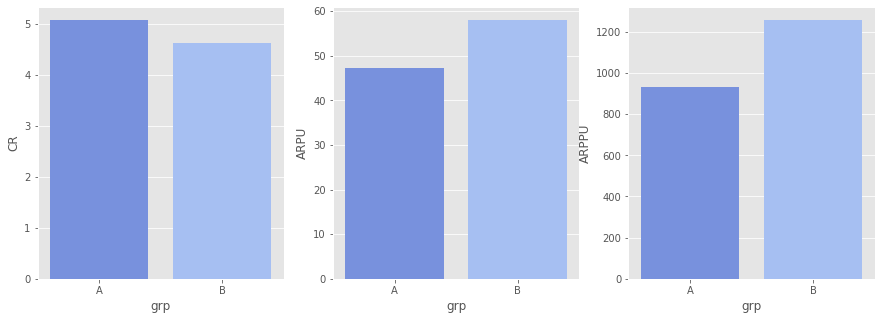

In [72]:
schedule()